In [4]:
# Load up packages
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import xarray as xr
import pandas as pd
from sklearn.tree import  DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import sys
import pickle
import os
import warnings
from tqdm import tqdm
import cartopy.crs as ccrs
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

sys.path.append('../..')
from src.models.ml_functions import  RF_regressor, plot_importances, XGBoost_regressor, Tu_label, encode_tulabel, XGBoost_regressor_tuned
from src.visualisation.visual_func import create_testdf, plot_std_lat, plot_residuals, stereo_plot
from src.models.corr_func import calc_correlation, plot_correlations
from src.utils.directories import get_parent_directory
from src.models.shapely_test import shap_plot

In [5]:
parent_dir = get_parent_directory()
parent_dir

'/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence'

In [6]:
# arctic_pkl = '/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/ml_ready/arctic2_1805.pkl'
arctic_pkl = (os.path.join(parent_dir, "data/processed/ml_ready/2706_time.pkl"))
arctic_df = pd.read_pickle(arctic_pkl)

In [7]:
from pickle import load
import matplotlib.pyplot as plt
import numpy as np
# =============================================================================
# Load in pickle file
# =============================================================================
filename = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/models/XGboost/SIC_xgboostMLD.sav"
# Previous pickle file returned a list so we will perform 
# multiple assignment here
model, X_train, X_test, Y_train, Y_test = load(open(filename, 'rb'))

In [8]:
# Get the predicted values
y_pred = model.predict(X_test)

In [9]:
# excluded 'sea_ice_concentration','latitude', 
xstringlist_all_SIC = ['depth', 'hab','S','T','dSdz','dTdz','log_N2', 'Tu_label', 'MLDJ', 'MLDI', 'Rsubrho', 'sea_ice_concentration', 'latitude', 'Tu']

# We want to predict:
ystringlist_all_SIC = ['log_eps']

In [10]:
from src.models.encode_features import encode_tulabeldict

arctic_df, labels = encode_tulabeldict(arctic_df)
# MLDJ generates better results than MLDI, also according to literature and visual inspectation
MLD_df = arctic_df[arctic_df['depth'] >= arctic_df['MLDJ']]

# Convert 'inf' and '-inf' to 'NaN'
MLD_df = MLD_df.replace([np.inf, -np.inf], np.nan)

# Drop rows with 'NaN' values
MLD_df = MLD_df.dropna()

In [11]:
y_pred_df_SIC = pd.DataFrame(y_pred, columns=ystringlist_all_SIC)
# Rename the 'eps_pred' column to 'log_eps'
y_pred_df_SIC = y_pred_df_SIC.rename(columns={'log_eps': 'eps_pred'})

# Reset index on y_pred_df_SIC and y_test_df_SIC
y_pred_df_SIC.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Create a new dataframe with index column
index_df_SIC = pd.DataFrame({'index': range(len(y_pred_df_SIC))})

SIC_all_testdf = create_testdf(X_test, Y_test, y_pred_df_SIC)
merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=["log_eps", "depth", "latitude"])

#merged_df_SIC = merged_df_SIC.drop_duplicates(subset=xstringlist_all+ystringlist)
residuals_SIC = (merged_df_SIC["log_eps"] - merged_df_SIC["eps_pred"])
merged_df_SIC["residuals"] = residuals_SIC
merged_df_SIC["abs_residuals"] = np.abs(residuals_SIC)
#stereo_plot(merged_df_SIC, abs(residuals_SIC), "Absolute residuals")
# merged_df_SIC = SIC_all_testdf.merge(MLD_df, on=xstringlist_all+ystringlist)

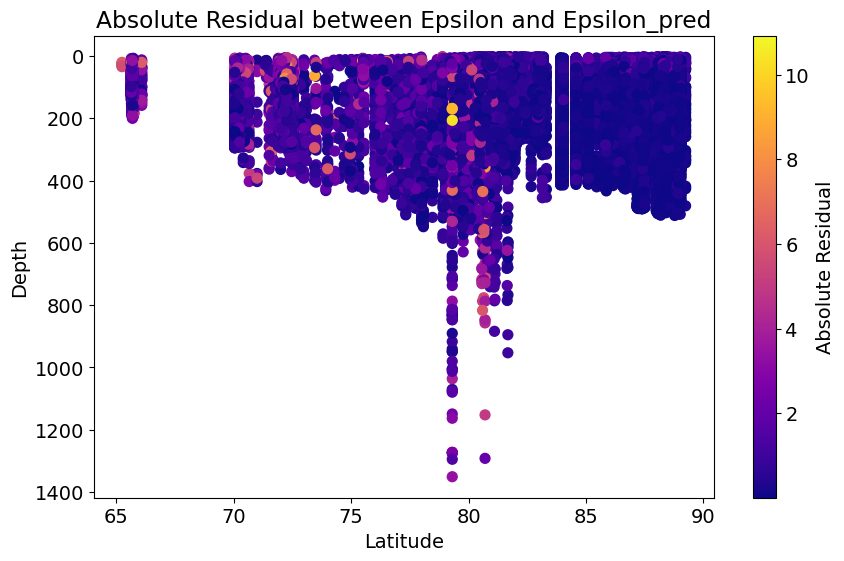

In [16]:
# arctic_all_testdf
plot_residuals(merged_df_SIC)

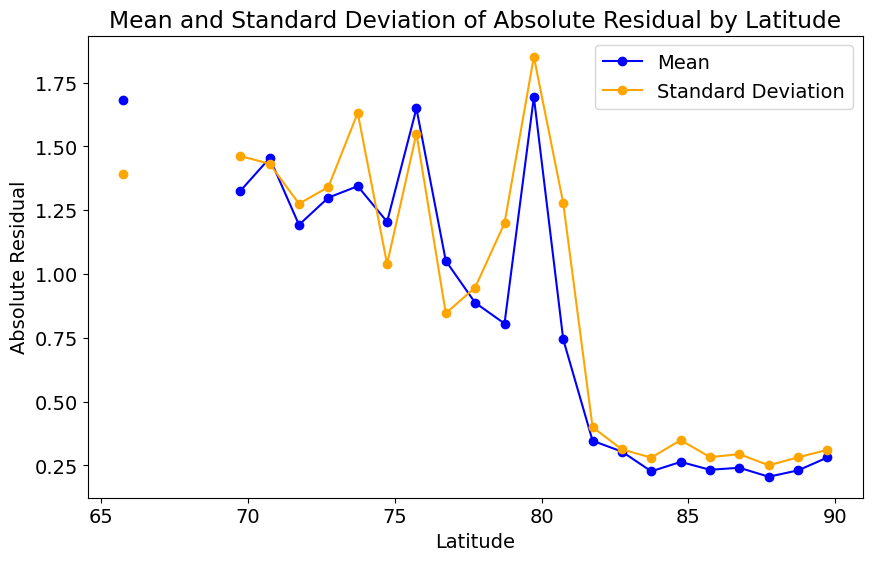

In [17]:
plot_std_lat(merged_df_SIC)

In [18]:
def plot_residuals(test_df):
    """
    Plots the absolute residuals between the true and predicted epsilon value
    as a scatter plot, limited to the top 300 meters.

    Parameters:
        test_df (pd.DataFrame): A dataframe containing the test data features,
        true epsilon values, and predicted epsilon values.

    Returns:
        None

    Example:
        # Assuming test_df is a dataframe with columns 'latitude', 'depth',
        # 'log_eps' (true epsilon values), and 'eps_pred'
        plot_residuals(test_df)
    """
    abs_residual = np.abs(test_df['log_eps'] - test_df['eps_pred'])

    # Limit the dataframe to the top 300 meters
    limited_df = test_df[test_df['depth'] <= 300]

    # Apply the same filtering to the abs_residual variable
    limited_abs_residual = abs_residual[test_df['depth'] <= 300]

    # Define the x and y coordinates for the scatter plot
    latitude = limited_df['latitude'].values
    depth = limited_df['depth'].values

    # Create a scatter plot of the absolute residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(latitude, depth, c=limited_abs_residual, cmap='plasma', s=50)
    plt.colorbar(label='Absolute Residual')
    plt.xlabel('Latitude')
    plt.ylabel('Depth')
    plt.title('Absolute Residual between Epsilon and Epsilon_pred (Top 300 meters)')

    # Invert the y-axis
    plt.gca().invert_yaxis()

    # Show the plot
    plt.show()


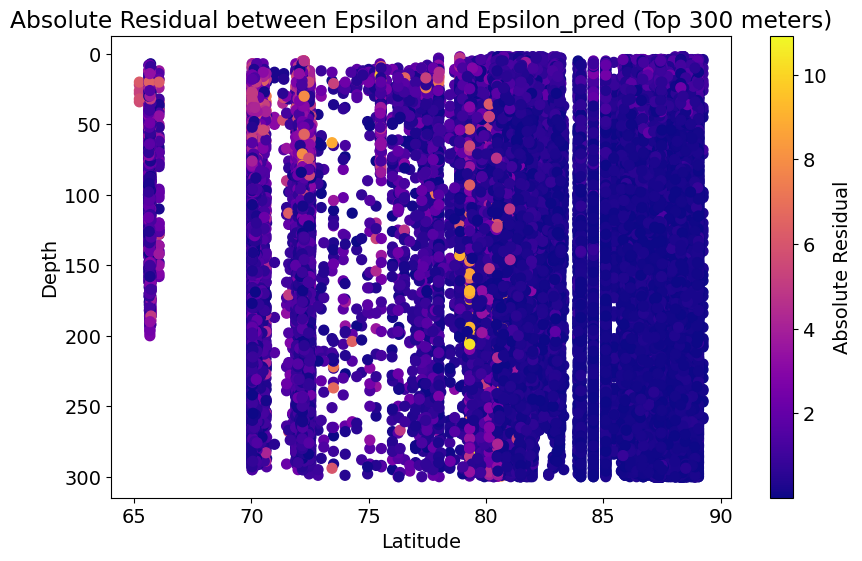

In [19]:
plot_residuals(merged_df_SIC)

ValueError: 'c' argument has 2500 elements, which is inconsistent with 'x' and 'y' with size 148352.

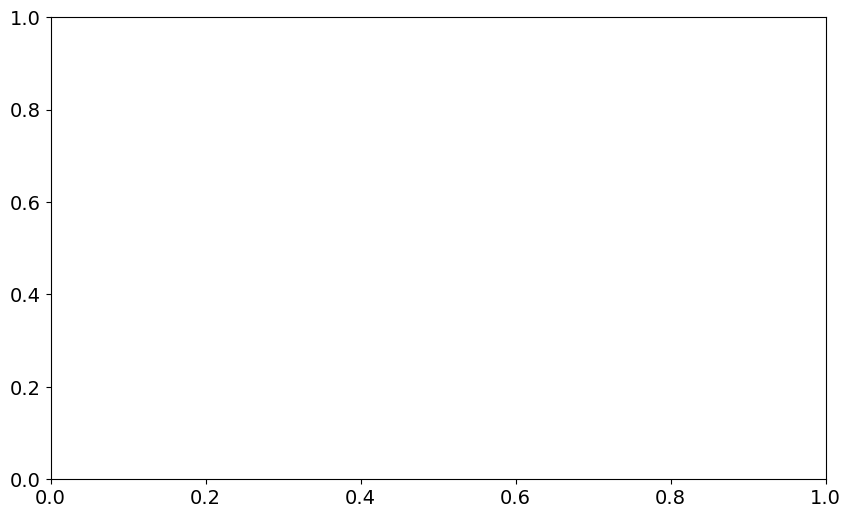

In [12]:
import matplotlib.pyplot as plt

# Assuming you have the following data arrays: latitude, depth, tu, and abs_residuals

# Function to calculate the point density
def calculate_density(x, y, bins):
    density, _, _ = np.histogram2d(x, y, bins=bins)
    return density

# Define the number of bins for density calculation
bins = 50

# Calculate point density
density = calculate_density(merged_df_SIC["latitude"], merged_df_SIC["abs_residuals"], bins)

# Plot scatter plot with density-based colors for absolute residuals vs latitude
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_SIC["latitude"], merged_df_SIC["abs_residuals"], c=density.flatten(), cmap='plasma', alpha=0.5)
plt.colorbar(label='Density')
plt.xlabel('Latitude')
plt.ylabel('Absolute Residual')
plt.title('Scatter Plot: Absolute Residuals vs Latitude')
plt.show()

# Calculate point density
density = calculate_density(merged_df_SIC["depth"], merged_df_SIC["abs_residuals"], bins)

# Plot scatter plot with density-based colors for absolute residuals vs depth
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_SIC["depth"], merged_df_SIC["abs_residuals"], c=density.flatten(), cmap='plasma', alpha=0.5)
plt.colorbar(label='Density')
plt.xlabel('Depth')
plt.ylabel('Absolute Residual')
plt.title('Scatter Plot: Absolute Residuals vs Depth')
plt.show()

# Calculate point density
density = calculate_density(merged_df_SIC["Tu_label_y"], merged_df_SIC["abs_residuals"], bins)

# Plot scatter plot with density-based colors for absolute residuals vs tu
plt.figure(figsize=(10, 6))
plt.scatter(merged_df_SIC["Tu_label_y"], merged_df_SIC["abs_residuals"], c=density.flatten(), cmap='plasma', alpha=0.5)
plt.colorbar(label='Density')
plt.xlabel('TU')
plt.ylabel('Absolute Residual')
plt.title('Scatter Plot: Absolute Residuals vs TU')
plt.show()
